In [1]:
# ----------Plotting functions---------- 
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

In [4]:
### For reading in .mcool files
#Define resolution & paths, read .mcool @ desired resolution
res = 10_000
mcool_dir = "/mnt/data0/noah/analysis/033023_loopAnalysis/hg19_cools/allMerged" #Path to all mcool files
mcool = "0hr_24hr_Granta519_MicroC_5000bp.cool" #cool filename 
clr = cooler.Cooler("{}/{}".format(mcool_dir, mcool))

In [5]:
### For reading in .cool files with a pre-determined resolution
res = 5_000
cool_dir = "/mnt/data0/noah/analysis/033023_loopAnalysis/hg19_cools/allMerged"
cool = "0hr_24hr_Granta519_MicroC_5000bp.cool"
clr = cooler.Cooler("{}/{}".format(cool_dir, cool))

In [8]:
#4 window sizes = 30_000, 50_000, 100_000, 250_000
insul_out = "/mnt/data0/noah/analysis/033023_loopAnalysis/item03_TADsWithCooltools/test_tadCalls"
fname = "allMerged_0hr24hr_cl27cl97_5kb_insulationScores.tsv"
windows = [20*res] # 4 different window sizes
insulation_table = insulation(clr, windows, verbose=True, threshold = 0.1) # Calculate insulation for all window sizes
insulation_table.to_csv("{}/{}".format(insul_out, fname), sep = "\t") # Write insulation table to csv

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


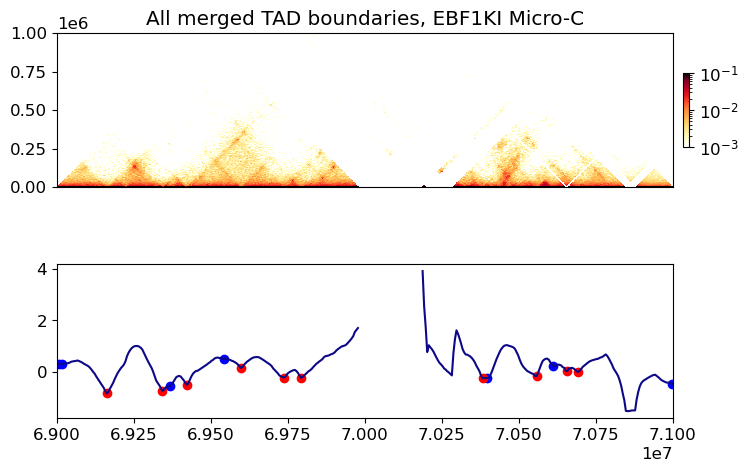

In [10]:
TITLE="All merged TAD boundaries, EBF1KI Micro-C" #Plot title
# ----------Define regions to view ----------
start = 69_000_000 # Start coord
end = start + 2_000_000 # End coord
region = ('chr16', start, end) # Full region - chr, start, end
# -------------------------------------------
# ----------Normalization init. and plotting / aethetics ----------
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, 
                      data, 
                      start=region[1], 
                      resolution=res, 
                      norm=norm, 
                      cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 10*windows[0])
ax.xaxis.set_visible(False)
ax.set_title(TITLE)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)
ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
# --------------------------------------------------------------------
insul_region = bioframe.select(insulation_table, region) # Selected region from big insulation score table
# ---------- Plotting results from 1 window size ----------
window = 0 #Window to use when plotting results
#Plot insulation score on other axis
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[window]}'], label=f'Window {windows[window]} bp') 

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])] # All boundaries
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[window]}']] #Weak boundaries - is_boundary==F
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[window]}']] #Strong boundarues - is_boundary==T
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
               weak_boundaries[f'log2_insulation_score_{windows[window]}'], 
               label='Weak boundaries', color = 'blue')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
               strong_boundaries[f'log2_insulation_score_{windows[window]}'], 
               label='Strong boundaries', color = 'red')